# House Price Prediction

In [267]:
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype, is_object_dtype, is_numeric_dtype
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV

In [269]:
df = pd.read_csv("AmesHousing.csv")

In [270]:
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


df.info()

In [272]:
for label, content in df.items():
    col = df[label]
    if pd.isnull(col).sum():
        print(f"{label}: {pd.isnull(col).sum()} --> {col.dtype}")

Lot Frontage: 490 --> float64
Alley: 2732 --> object
Mas Vnr Type: 1775 --> object
Mas Vnr Area: 23 --> float64
Bsmt Qual: 80 --> object
Bsmt Cond: 80 --> object
Bsmt Exposure: 83 --> object
BsmtFin Type 1: 80 --> object
BsmtFin SF 1: 1 --> float64
BsmtFin Type 2: 81 --> object
BsmtFin SF 2: 1 --> float64
Bsmt Unf SF: 1 --> float64
Total Bsmt SF: 1 --> float64
Electrical: 1 --> object
Bsmt Full Bath: 2 --> float64
Bsmt Half Bath: 2 --> float64
Fireplace Qu: 1422 --> object
Garage Type: 157 --> object
Garage Yr Blt: 159 --> float64
Garage Finish: 159 --> object
Garage Cars: 1 --> float64
Garage Area: 1 --> float64
Garage Qual: 159 --> object
Garage Cond: 159 --> object
Pool QC: 2917 --> object
Fence: 2358 --> object
Misc Feature: 2824 --> object


## Categorical Variables

In [274]:
def train_cats(df):
    for label, content in df.items():
        if is_object_dtype(content):
            df[label] = content.astype("category").cat.as_ordered()

In [275]:
def apply_cats(df,train):
    for label, content in df.items():
        if train[label].dtype == "category":
            df[label] = pd.Categorical(content,categories = train[label].cat.categories, ordered = True)

In [276]:
def numericalize(df,col,name):
    if not is_numeric_dtype(col):
        df[name] = col.cat.codes + 1

In [277]:
train_cats(df)

## Handling Missing Values

In [279]:
def fix_missing(df, col, name, nan_dict, is_train):
    if is_train:
        if is_numeric_dtype(col):
            if pd.isnull(col).sum():
                df[name+"_na"] = pd.isnull(col)
                nan_dict[name] = col.median()
                df[name] = col.fillna(nan_dict[name])
    else:
        if is_numeric_dtype(col):
            if name in nan_dict:
                df[name+"_na"] = pd.isnull(col)
                df[name] = col.fillna(nan_dict[name])

            else:
                df[name] = col.fillna(df[name].median())

In [280]:
def proc_df(df, y_fld, nan_dict=None, is_train= True):
    df = df.copy()
    y = df[y_fld].values

    df.drop(y_fld, axis = 1, inplace = True)

    if nan_dict is None:
        nan_dict = {}

    for label, content in df.items():
        fix_missing(df, content, label, nan_dict, is_train)
        numericalize(df, content, label)

    if is_train:
        return df, y, nan_dict

    return df, y

In [281]:
def split_train_val(df, n):
    return df[:n].copy(), df[n:].copy()

In [282]:
n_valid = 2100
n_train = len(df) - n_valid
raw_train, raw_valid = split_train_val(df, n_train)

In [283]:
x_train, y_train, nas = proc_df(raw_train, 'SalePrice')

In [284]:
x_valid, y_valid = proc_df(raw_valid, 'SalePrice', nan_dict = nas, is_train = False)

In [285]:
x_train.isnull().sum()

Order               0
PID                 0
MS SubClass         0
MS Zoning           0
Lot Frontage        0
                   ..
Sale Type           0
Sale Condition      0
Lot Frontage_na     0
Mas Vnr Area_na     0
Garage Yr Blt_na    0
Length: 84, dtype: int64

In [286]:
x_valid.isnull().sum()

Order               0
PID                 0
MS SubClass         0
MS Zoning           0
Lot Frontage        0
                   ..
Sale Type           0
Sale Condition      0
Lot Frontage_na     0
Mas Vnr Area_na     0
Garage Yr Blt_na    0
Length: 84, dtype: int64

## Models

### XGBoost

In [289]:
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(x_train, y_train)
y_pred_xgb = xgb_model.predict(x_valid)

rmsle_train = mean_squared_log_error(y_train, xgb_model.predict(x_train), squared=False)
rmsle_valid = mean_squared_log_error(y_valid, y_pred_xgb, squared=False)
print("RMSLE of train set:", rmsle_train)
print("RMSLE of valid set:", rmsle_valid)

RMSLE of train set: 0.00256043228459213
RMSLE of valid set: 0.15308314209570822


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:675: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared logarithmic error, use the function'root_mean_squared_log_error'.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:675: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared logarithmic error, use the function'root_mean_squared_log_error'.
  warnings.warn(


### Random Forest Regressor

In [291]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_valid)

rmsle_train = mean_squared_log_error(y_train, rf.predict(x_train), squared=False)
rmsle_valid = mean_squared_log_error(y_valid, y_pred_rf, squared=False)
print("RMSLE of train set:", rmsle_train)
print("RMSLE of valid set:", rmsle_valid)

RMSLE of train set: 0.07163246294674934
RMSLE of valid set: 0.145207621255775


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:675: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared logarithmic error, use the function'root_mean_squared_log_error'.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:675: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared logarithmic error, use the function'root_mean_squared_log_error'.
  warnings.warn(


- Recursive Feature Elimination (RFE)

In [293]:
# RandomForest with RFE
rfe = RFE(estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select=20)
rfe.fit(x_train, y_train)

selected_features = x_train.columns[rfe.support_]
print("Selected features:", list(selected_features))

# Transforming data
x_train_rfe = rfe.transform(x_train)
x_valid_rfe = rfe.transform(x_valid)

# Training model with RFE
rf_rfe = RandomForestRegressor(n_estimators=100, random_state=42)
rf_rfe.fit(x_train_rfe, y_train)

y_val_pred_rfe = rf_rfe.predict(x_valid_rfe)

rmsle_train = mean_squared_log_error(y_train, rf_rfe.predict(x_train_rfe), squared=False)
rmsle_valid = mean_squared_log_error(y_valid, y_val_pred_rfe, squared=False)
print("RMSLE of train set:", rmsle_train)
print("RMSLE of valid set:", rmsle_valid)

Selected features: ['PID', 'Lot Frontage', 'Lot Area', 'Overall Qual', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'Exter Qual', 'BsmtFin SF 1', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', 'Gr Liv Area', 'Kitchen Qual', 'TotRms AbvGrd', 'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Open Porch SF', 'Mo Sold']
RMSLE of train set: 0.07651894783358014
RMSLE of valid set: 0.15279333120030378


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:675: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared logarithmic error, use the function'root_mean_squared_log_error'.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:675: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared logarithmic error, use the function'root_mean_squared_log_error'.
  warnings.warn(


- Hyperparameter tuning

In [295]:
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 4],
    'max_features': ['sqrt', 'log2', None]  # "auto" kaldırıldı, None eklendi
}

# GridSearchCV
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=3,
                           scoring='neg_mean_squared_log_error',  # RMSLE için negatif MSE log kullanıyoruz
                           n_jobs=-1,
                           verbose=2)

# Fitting the model
grid_search.fit(x_train_rfe, y_train)

print("Best parameters:", grid_search.best_params_)

# En iyi model
best_rf = grid_search.best_estimator_

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [296]:
# Train prediction and RMSLE
y_train_pred = best_rf.predict(x_train_rfe)
train_rmsle = np.sqrt(mean_squared_log_error(y_train, y_train_pred))
    
# Validation prediction and RMSLE
y_val_pred = best_rf.predict(x_valid_rfe)
val_rmsle = np.sqrt(mean_squared_log_error(y_valid, y_val_pred))
    
print(f"Train RMSLE: {train_rmsle:.5f}")
print(f"Validation RMSLE: {val_rmsle:.5f}")

Train RMSLE: 0.07652
Validation RMSLE: 0.15279


- Feature importance

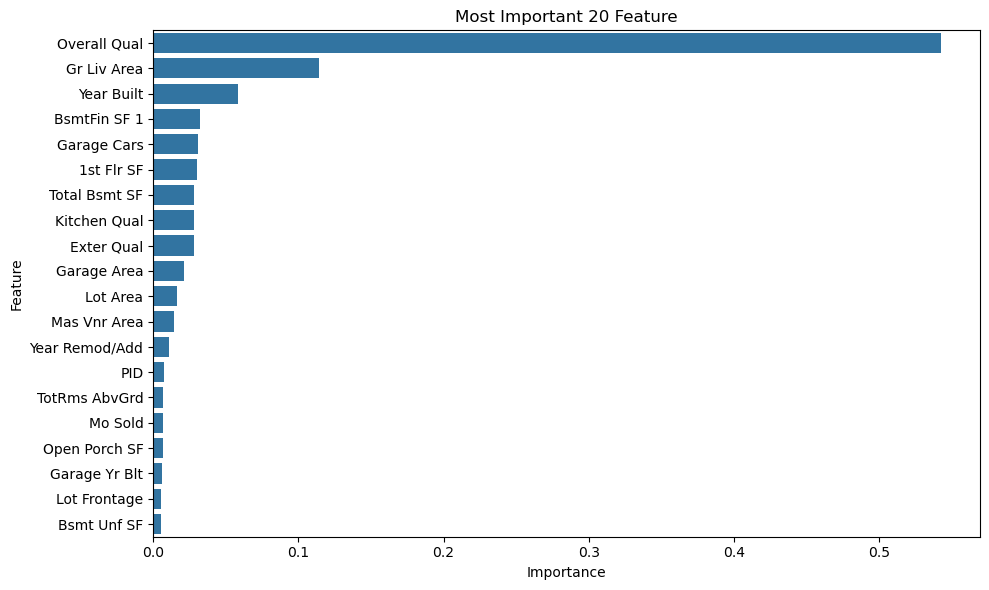

In [324]:
selected_features = x_train.columns[rfe.support_]
importances = best_rf.feature_importances_

feat_df = pd.DataFrame({'Feature': selected_features, 'Importance': importances})
feat_df = feat_df.sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_df)
plt.title("Most Important 20 Feature")
plt.tight_layout()
plt.show()